In [2]:
!pip install osmnx
!pip install folium
!pip install networkx
!pip install math
!pip install requests
!pip install time

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.4/101.4 kB 2.3 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement math (from versions: none)
ERROR: No matching distribution found for math
ERROR: Could not find a version that satisfies the requirement time (from versions: none)
ERROR: No matching distribution found for time


In [3]:
import osmnx as ox
import folium
import requests
import math
import time
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
# from tqdm import tqdm


In [4]:
# Function to find the closest site to a given point using API1
def find_closest_site(point):
    api1_url = "https://webtris.nationalhighways.co.uk/api/v1.0/sites"
    response = requests.get(api1_url)
    if response.status_code == 200:
        sites_data = response.json()["sites"]
        closest_site = min(sites_data, key=lambda site: (site["Latitude"] - point[0]) ** 2 + (site["Longitude"] - point[1]) ** 2)
        return closest_site
    else:
        return None

In [5]:

# Define the addresses for the starting, intermediate, and ending points
start_address = "Nursling, Southampton"  # Replace with the actual start address
intermediate_addresses = ["Basingstoke, Hampshire",  "Frimley, Hampshire"]  # Replace with actual intermediate addresses
end_address = "Thorpe, Surrey" # Replace with the actual end address



In [6]:
# Geocode the addresses to obtain the coordinates
start_point = ox.geocode(start_address)
intermediate_points = [ox.geocode(address) for address in intermediate_addresses]
end_point = ox.geocode(end_address)

In [7]:
print(start_point,intermediate_points, end_point)

(50.9288036, -1.4729034) [(51.262826, -1.0861976), (51.3139645, -0.7639195)] (51.408913, -0.5329621)


In [8]:
# Find the closest sites to each address using API1
closest_start_site = find_closest_site(start_point)
closest_intermediate_sites = [find_closest_site(point) for point in intermediate_points]
closest_end_site = find_closest_site(end_point)

In [9]:
# Obtain the graph for the area
graph = ox.graph_from_point(start_point, dist=90000, custom_filter='["highway"~"motorway"]')


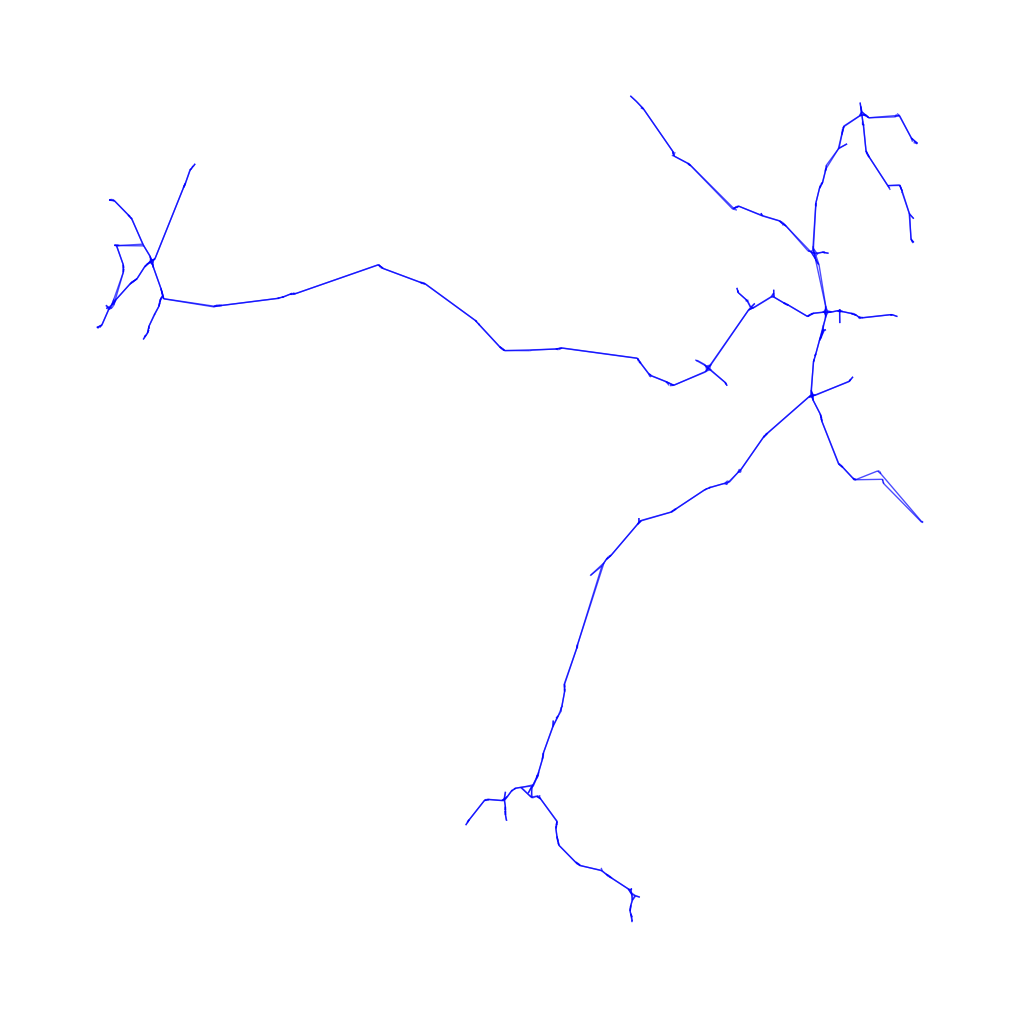

In [10]:
# Convert the graph to a NetworkX graph (optional but useful for visualization)
G = nx.Graph(graph)

# Plot the graph using Matplotlib
plt.figure(figsize=(10, 10))  # Adjust the figure size as needed
pos = {node: (data['x'], data['y']) for node, data in G.nodes(data=True)}
nx.draw(G, pos, node_size=0, with_labels=False, edge_color='b', node_color='r', alpha=0.7)

# Show the plot
# plt.axis('off')  # Turn off axis labels and ticks
plt.show()

In [11]:
# Find the nearest nodes to the starting, intermediate, and ending points
start_node = ox.distance.nearest_nodes(graph, start_point[1], start_point[0])
intermediate_nodes = [ox.distance.nearest_nodes(graph, point[1], point[0]) for point in intermediate_points]
end_node = ox.distance.nearest_nodes(graph, end_point[1], end_point[0])

# Create a list of all nodes including the start, intermediate, and end nodes
all_nodes = [start_node] + intermediate_nodes + [end_node]


# Initialize an empty list to store the edges of the shortest path
shortest_path_edges = []

# Iterate over adjacent pairs of nodes to calculate the shortest path
for i in range(len(all_nodes) - 1):
    source_node = all_nodes[i]
    target_node = all_nodes[i + 1]

    # Find the shortest path
    path = ox.shortest_path(graph, source_node, target_node, weight='length')

    if path is not None and len(path) > 1:
        # Create triplets (u, v, key)
        path_edges = list(zip(path[:-1], path[1:], [0] * (len(path) - 1)))
        shortest_path_edges.extend(path_edges)
        # Create a new graph that only includes the edges of the shortest path
        shortest_path_graph = graph.edge_subgraph(shortest_path_edges)

        # Convert the shortest path to a GeoDataFrame
        route_gdf = ox.graph_to_gdfs(shortest_path_graph, nodes=False)
        print(path_edges)
    else:
        print(f"No valid path between nodes {source_node} and {target_node}")


[(254980, 254983, 0), (254983, 254988, 0), (254988, 913819708, 0), (913819708, 325699, 0), (325699, 325702, 0), (325702, 325703, 0), (325703, 325701, 0), (325701, 20961031, 0), (20961031, 21189063, 0), (21189063, 325033, 0), (325033, 324990, 0), (324990, 298274, 0), (298274, 298256, 0), (298256, 256755866, 0), (256755866, 17723035, 0), (17723035, 1597430090, 0), (1597430090, 298222, 0), (298222, 1596591886, 0), (1596591886, 1596591990, 0), (1596591990, 305166, 0), (305166, 1589976160, 0), (1589976160, 302458, 0), (302458, 1593538334, 0), (1593538334, 298001, 0), (298001, 13101520, 0), (13101520, 1584328112, 0), (1584328112, 302308, 0)]
[(302308, 1574556835, 0), (1574556835, 1582524511, 0), (1582524511, 1586039984, 0), (1586039984, 1594841278, 0), (1594841278, 1594841310, 0), (1594841310, 297408, 0), (297408, 1595057631, 0), (1595057631, 1595057806, 0)]
[(1595057806, 1595124974, 0), (1595124974, 6020113693, 0), (6020113693, 1595221224, 0), (1595221224, 1595261953, 0), (1595261953, 20242

In [12]:
# Create a folium map centered around the starting point
m = folium.Map(location=start_point, zoom_start=15)

# Add markers for the starting, intermediate, and ending points with tooltips showing their addresses
folium.Marker(start_point,  tooltip=start_address).add_to(m)
for point, address in zip(intermediate_points, intermediate_addresses):
    folium.Marker(point,  tooltip=address).add_to(m)
folium.Marker(end_point,  tooltip=end_address).add_to(m)

m

In [13]:
route_gdf

,,,osmid,oneway,lanes,highway,maxspeed,reversed,length,geometry,ref,name,junction,bridge
u,v,key,,,,,,,,,,,,
1595261953,202422,0,"[146367633, 184361582]",True,3,motorway_link,70 mph,False,382.264,"LINESTRING (-0.54694 51.39916, -0.54558 51.399...",NaN,NaN,NaN,NaN
254980,254983,0,"[368493984, 1169717905, 1169717906, 1169717908...",True,2,motorway,70 mph,False,1089.361,"LINESTRING (-1.47290 50.92880, -1.47328 50.930...",M271,Nursling Spur Motorway,NaN,NaN
254983,254988,0,"[368493984, 993947726, 367489992]",True,"[3, 2]",motorway,70 mph,False,759.200,"LINESTRING (-1.47323 50.93854, -1.47327 50.939...",M271,Nursling Spur Motorway,NaN,NaN
20961031,21189063,0,"[1169717928, 93147728, 1169717927]",True,4,motorway,70 mph,False,1103.403,"LINESTRING (-1.46673 50.94973, -1.46644 50.949...",M27,NaN,NaN,NaN
254988,913819708,0,136186555,True,3,motorway,70 mph,False,19.993,"LINESTRING (-1.47631 50.94495, -1.47658 50.94501)",M271,Rownhams Interchange,circular,NaN
1596591886,1596591990,0,146385961,True,3,motorway,70 mph,False,777.942,"LINESTRING (-1.31204 51.04019, -1.31151 51.040...",M3,NaN,NaN,NaN
1595057806,1595124974,0,"[44107076, 146229476, 146235333, 146229483, 44...",True,3,motorway,70 mph,False,689.574,"LINESTRING (-0.76392 51.31396, -0.76250 51.314...",M3,NaN,NaN,yes
298256,256755866,0,"[146454529, 23711234, 23711235]",True,3,motorway,70 mph,False,557.582,"LINESTRING (-1.37867 50.96972, -1.37757 50.970...",M3,NaN,NaN,yes
298001,13101520,0,"[126420185, 23454218, 951327]",True,3,motorway,70 mph,False,1265.756,"LINESTRING (-1.17858 51.20880, -1.17760 51.209...",M3,NaN,NaN,yes


### Site ID based route order


In [14]:
# Create a list of siteIDs in the geographical route order
site_ids_route_order = []
for index, row in route_gdf.iterrows():
    line_geometry = row["geometry"]

    midpoint = line_geometry.interpolate(0.5, normalized=True)  # Get the midpoint of the edge
    print(midpoint)
    # Find the closest site to the midpoint of the path edge
    closest_site = find_closest_site((midpoint.y, midpoint.x))

    if closest_site:
        site_ids_route_order.append(closest_site["Id"])

print(site_ids_route_order)

POINT (-0.5444841553067257 51.39992049222134)
POINT (-1.4737520874900019 50.93364263194845)
POINT (-1.474182977645224 50.94206027716882)
POINT (-1.4606247043150917 50.95292428533182)
POINT (-1.47644625 50.944979000000004)
POINT (-1.3077204262435138 51.04201904650226)
POINT (-0.7596163527812019 51.31554388268559)
POINT (-1.3765298831405293 50.971811393922344)
POINT (-1.1719435800955367 51.21281180251662)
POINT (-1.2920615256750803 51.071943068238866)
POINT (-1.3668434803082137 50.98195481356461)
POINT (-1.3585359096387861 50.99460982816981)
POINT (-0.6800808874744647 51.35620166261906)
POINT (-1.2247442177606653 51.17205455067636)
POINT (-1.3829865077404948 50.9657709161836)
POINT (-1.0125614357622783 51.266292711334636)
POINT (-1.4326856318018584 50.96013002777809)
POINT (-0.9082181021537727 51.28812874505738)
POINT (-1.1101045085509422 51.23749063976666)
POINT (-0.539491367713825 51.40327540298782)
POINT (-1.4771009165431384 50.945607192476686)
POINT (-0.8537680200418726 51.2964376410

In [15]:
route_gdf["site_id"] = site_ids_route_order

In [16]:
# Initialize an empty list to store the distances
distances_between_sites = []

# Iterate through the DataFrame
for i in range(1, len(route_gdf)):
    # Get the current and previous rows
    current_row = route_gdf.iloc[i]
    previous_row = route_gdf.iloc[i - 1]

    # Extract the site IDs and lengths
    current_site_id = current_row["site_id"]
    previous_site_id = previous_row["site_id"]
    length = current_row["length"]

    # Calculate the distance between site IDs
    distance_between_sites = {"from": previous_site_id, "to": current_site_id, "distance": length}

    # Append the distance to the list
    distances_between_sites.append(distance_between_sites)

# Convert the list of distances to a DataFrame
distance_df = pd.DataFrame(distances_between_sites)

# Print the DataFrame showing distances between site IDs
print(distance_df)


     from     to   distance
0    8922   7588   1089.361
1    7588   7587    759.200
2    7587  15593   1103.403
3   15593  13725     19.993
4   13725  15638    777.942
5   15638  14428    689.574
6   14428   8871    557.582
7    8871  15630   1265.756
8   15630   2753    993.383
9    2753   2654   2138.044
10   2654   4703    865.874
11   4703   7621    946.928
12   7621   7598  11355.786
13   7598     23   1021.549
14     23   6311   6426.354
15   6311    238   1205.670
16    238   7612   6991.729
17   7612   6314   6718.634
18   6314  14453    752.573
19  14453   7312    164.641
20   7312  15621   1022.568
21  15621  14486    917.381
22  14486   7312     15.832
23   7312   4679    750.340
24   4679  13725     79.285
25  13725   3840    995.587
26   3840  13725     16.160
27  13725   5210   4044.671
28   5210   7603   1187.800
29   7603   6310   3128.262
30   6310   7609   1041.405
31   7609  14569   2126.280
32  14569  11809   5301.257
33  11809   7607   1056.824
34   7607  14559  10

In [17]:
distance_df.sum()

from        8922758875871559313725156381442888711563027532...
to          7588758715593137251563814428887115630275326544...
distance                                            91633.398
dtype: object

### Map based on elevation and fuel consumption


In [20]:


elevation_data = []
for index, row in route_gdf.iterrows():
    lon, lat = row.geometry.coords[0]
    url = f"https://api.opentopodata.org/v1/eudem25m?locations={lat},{lon}"
    response = requests.get(url)

    elevation = response.json()["results"][0]["elevation"]
    elevation_data.append(elevation)
    time.sleep(1)

# Add elevation data as a column in the route GeoDataFrame
route_gdf["elevation"] = elevation_data

# Calculate the change in elevation (angle 'phi') as the slope or incline
delta_phi = [0]  # Initialize the change in elevation
for i in range(1, len(elevation_data)):
    delta_phi.append(math.radians(elevation_data[i] - elevation_data[i - 1]))

# Add the change in elevation as a column in the route GeoDataFrame
route_gdf["delta_phi"] = delta_phi



### Loading API data in a json format and Calculating avg speed



In [ ]:
date_list = [
 '06012019', '13012019', '20012019', '27012019',
 '03022019', '10022019', '17022019', '24022019',
 '03032019', '10032019', '17032019', '24032019', '31032019',
 '07042019', '14042019', '21042019', '28042019',
 '05052019', '12052019', '19052019', '26052019',
 '02062019', '09062019', '16062019', '23062019', '30062019',
 '07072019', '14072019', '21072019', '28072019',
 '04082019', '11082019', '18082019', '25082019',
 '01092019', '08092019', '15092019', '22092019', '29092019',
 '06102019', '13102019', '20102019', '27102019',
 '03112019', '10112019', '17112019', '24112019',
 '01122019', '08122019', '15122019', '22122019', '29122019'
]




In [ ]:
import json
import requests

# User input for start time
user_start_time = "13:44"
user_start_hour, user_start_minute = map(int, user_start_time.split(":"))
current_timestamp = user_start_hour * 60 + user_start_minute

# Initialize a dictionary to store the timestamps and average speeds at each site
site_timestamps = {}

# Initialize current average speed
current_speed = 70  # Default speed if no data is available

# Iterate through the sites in site_ids_route_order

for sunday_date in date_list:
  site_timestamps = {}
  for site_id in site_ids_route_order:
      # Check if there is available average speed data for the current site from the API
      api_url = f"https://webtris.nationalhighways.co.uk/api/v1.0/reports/daily?sites={site_id}&start_date={sunday_date}&end_date={sunday_date}&page=1&page_size=39999"
      response = requests.get(api_url)

      if response.status_code == 200:
          avg_speed_data = response.json()["Rows"]
          for entry in avg_speed_data:
              # Check if the timestamp in the API response matches the current timestamp
              if entry["Time Interval"] == str(int(current_timestamp / 60)) and entry["Time Interval"] != "59":
                  # Check if "Avg mph" is a valid number
                  avg_mph = entry["Avg mph"]
                  if avg_mph and avg_mph.isdigit():
                      # Update the current average speed with the API data
                      current_speed = int(avg_mph)
                  break

      # Add the current site, timestamp, and average speed to the dictionary
      hours = current_timestamp // 60
      minutes = current_timestamp % 60
      site_timestamps[site_id] = {"timestamp": f"{hours:02}:{minutes:02}", "average_speed_mph": current_speed}
      try:
        # Calculate the time to travel to the next site using the current average speed
        if site_id != site_ids_route_order[-1]:
            distance_to_next_site_meters = distance_df.loc[(distance_df['from'] == site_id) & (distance_df['to'] == site_ids_route_order[site_ids_route_order.index(site_id) + 1])]['distance'].values[0]
            distance_to_next_site_miles = distance_to_next_site_meters * 0.000621371  # Convert meters to miles
            time_to_reach_next = distance_to_next_site_miles / current_speed  # Time in hours
            current_timestamp += int(time_to_reach_next * 60)  # Convert hours to minutes and update timestamp
      except OverflowError as e:
        continue

  # Convert the dictionary to JSON
  site_timestamps_json = json.dumps(site_timestamps, indent=4)

  # Print or use site_timestamps_json as needed
  # print(site_timestamps_json)
  # LDV vehicles

  Fk = 0.23
  Nk = 35
  Vk = 3
  Ak = 5
  Ckd = 0.32
  Ckr = 0.01
  rk = 0
  wk = 2300
  kappa = 45
  epsi = 0.4
  EP = 0.9
  xi = 1
  psi = 737
  rho = 1.2041
  g = 9.81

  conversion_factor = 0.44704  # Conversion factor from mph to m/s

  subroute_ldv_fuel_consumptions = []  # Store the fuel consumption for each subroute
  distance_covered = 0
  d_covered = []

  for index, (idx, row) in enumerate(route_gdf.iterrows()):
      d = row.length
      phi = row.delta_phi
      x = 500

      # Get the corresponding site ID from site_ids_route_order
      site_id = site_ids_route_order[index]

      # Get the average speed from site_timestamps, or assume 70 mph if not found
      avg_speed_mph = site_timestamps.get(site_id, {"average_speed_mph": 70})["average_speed_mph"]
      avg_speed_mps = avg_speed_mph * conversion_factor

      distance_covered += d
      d_covered.append(distance_covered)
      try:
        ldv_fuel = (((xi * Fk * Nk * Vk / (kappa * psi))) * (d / avg_speed_mps)) + ((1 / (1000 * epsi * EP * kappa * psi)) * (rk + g * math.sin(phi) + g * Ckr * math.cos(phi)) * (wk + x)) + (0.5 * Ckd * Ak * rho * d * (avg_speed_mps ** 2) / (1000 * epsi * EP * kappa * psi))
        subroute_ldv_fuel_consumptions.append(ldv_fuel)
      except ZeroDivisionError as e:
        continue
  print(sum(subroute_ldv_fuel_consumptions))




In [21]:
import json
import requests

# User input for start time
user_start_time = input("Enter start time (hh:mm): ")
user_start_hour, user_start_minute = map(int, user_start_time.split(":"))
current_timestamp = user_start_hour * 60 + user_start_minute

# Initialize a dictionary to store the timestamps and average speeds at each site
site_timestamps = {}

# Initialize current average speed
current_speed = 70  # Default speed if no data is available

average_speeds = []

# Iterate through the sites in site_ids_route_order

for site_id in site_ids_route_order:
    # Check if there is available average speed data for the current site from the API
    api_url = f"https://webtris.nationalhighways.co.uk/api/v1.0/reports/daily?sites={site_id}&start_date=01032020&end_date=01032020&page=1&page_size=39999"
    response = requests.get(api_url)

    if response.status_code == 200:
        avg_speed_data = response.json()["Rows"]
        for entry in avg_speed_data:
            # Check if the timestamp in the API response matches the current timestamp
            if entry["Time Interval"] == str(int(current_timestamp / 60)) and entry["Time Interval"] != "59":
                # Check if "Avg mph" is a valid number
                avg_mph = entry["Avg mph"]
                if avg_mph and avg_mph.isdigit():
                    # Update the current average speed with the API data
                    current_speed = int(avg_mph)
                break

    # Add the current site, timestamp, and average speed to the dictionary
    hours = current_timestamp // 60
    minutes = current_timestamp % 60
    site_timestamps[site_id] = {"timestamp": f"{hours:02}:{minutes:02}", "average_speed_mph": current_speed}

    average_speeds.append(current_speed)

    # Calculate the time to travel to the next site using the current average speed
    if site_id != site_ids_route_order[-1]:
        distance_to_next_site_meters = distance_df.loc[(distance_df['from'] == site_id) & (distance_df['to'] == site_ids_route_order[site_ids_route_order.index(site_id) + 1])]['distance'].values[0]
        distance_to_next_site_miles = distance_to_next_site_meters * 0.000621371  # Convert meters to miles
        time_to_reach_next = distance_to_next_site_miles / current_speed  # Time in hours
        current_timestamp += int(time_to_reach_next * 60)  # Convert hours to minutes and update timestamp

# Convert the dictionary to JSON
site_timestamps_json = json.dumps(site_timestamps, indent=4)

# Print or use site_timestamps_json as needed
print(site_timestamps_json)


Enter start time (hh:mm): 13:44
{
    "8922": {
        "timestamp": "13:44",
        "average_speed_mph": 70
    },
    "7588": {
        "timestamp": "13:44",
        "average_speed_mph": 57
    },
    "7587": {
        "timestamp": "13:44",
        "average_speed_mph": 52
    },
    "15593": {
        "timestamp": "13:44",
        "average_speed_mph": 52
    },
    "13725": {
        "timestamp": "14:03",
        "average_speed_mph": 57
    },
    "15638": {
        "timestamp": "13:44",
        "average_speed_mph": 52
    },
    "14428": {
        "timestamp": "13:44",
        "average_speed_mph": 67
    },
    "8871": {
        "timestamp": "13:44",
        "average_speed_mph": 67
    },
    "15630": {
        "timestamp": "13:44",
        "average_speed_mph": 67
    },
    "2753": {
        "timestamp": "13:44",
        "average_speed_mph": 62
    },
    "2654": {
        "timestamp": "13:45",
        "average_speed_mph": 62
    },
    "4703": {
        "timestamp": "13:45",
    

In [22]:
# Extract average speeds from the site_timestamps dictionary and store them in an array
average_speeds = [entry["average_speed_mph"] for entry in site_timestamps.values()]

# Print or use the average_speeds array as needed
print(average_speeds)

[70, 57, 52, 52, 57, 52, 67, 67, 67, 62, 62, 61, 61, 61, 55, 68, 68, 46, 66, 59, 64, 64, 64, 47, 57, 36, 36, 63, 74, 74, 59, 61, 61, 61, 61, 59, 58]


In [23]:
# Extract start and end timestamps
start_timestamp = site_timestamps["8922"]["timestamp"]
end_timestamp = site_timestamps["13301"]["timestamp"]

# Convert timestamps to minutes past midnight
def convert_to_minutes(timestamp):
    hours, minutes = map(int, timestamp.split(":"))
    # Since it goes past midnight, if hours is 24 we need to reset it to 0
    hours = hours if hours < 24 else 0
    return hours * 60 + minutes

start_minutes = convert_to_minutes(start_timestamp)
end_minutes = convert_to_minutes(end_timestamp)

# Calculate the difference in minutes
journey_time_in_minutes = end_minutes - start_minutes

journey_time_in_minutes

37

### Light Duty Vehicles

In [63]:
# LDV vehicles

Fk = 0.23
Nk = 35
Vk = 3
Ak = 5
Ckd = 0.32
Ckr = 0.01
rk = 0
wk = 2300
kappa = 45
epsi = 0.4
EP = 0.9
xi = 1
psi = 737
rho = 1.2041
g = 9.81



In [74]:
conversion_factor = 0.44704  # Conversion factor from mph to m/s

# subroute_ldv_fuel_consumptions = []  # Store the fuel consumption for each subroute
distance_covered = 0
d_covered = []
for i in range (-45,50,5):
  subroute_ldv_fuel_consumptions = []
  # print(i)
  for index, (idx, row) in enumerate(route_gdf.iterrows()):
      d = row.length
      phi = math.radians(i)
      x = 500

      # Get the corresponding site ID from site_ids_route_order
      site_id = site_ids_route_order[index]

      # Get the average speed from site_timestamps, or assume 70 mph if not found
      avg_speed_mph = site_timestamps.get(site_id, {"average_speed_mph": 70})["average_speed_mph"]
      avg_speed_mps = avg_speed_mph * conversion_factor

      distance_covered += d
      d_covered.append(distance_covered)

      ldv_fuel = (((xi * Fk * Nk * Vk / (kappa * psi))) * (d / avg_speed_mps)) + ((1 / (1000 * epsi * EP * kappa * psi)) * (rk + g * math.sin(phi) + g * Ckr * math.cos(phi)) * (wk + x)) + (0.5 * Ckd * Ak * rho * d * (avg_speed_mps ** 2) / (1000 * epsi * EP * kappa * psi))
      subroute_ldv_fuel_consumptions.append(ldv_fuel)
  print(sum(subroute_ldv_fuel_consumptions))

# route_gdf["ldv_fuel_consumption"] = subroute_ldv_fuel_consumptions


7.8564703325933944
7.862592853657219
7.8691713152472325
7.8761556512985536
7.883492706796574
7.891126642318718
7.898999359006165
7.907050940731251
7.915220110095365
7.923444694786971
7.931662100750424
7.939809788564537
7.947825749405333
7.955648976970652
7.963219931774921
7.970480994280614
7.977376903417709
7.983855177153817
7.989866511914114


In [36]:
payload = [0, 0.25, 0.5, 0.75, 1]
for load in payload:
  conversion_factor = 0.44704  # Conversion factor from mph to m/s

  subroute_ldv_fuel_consumptions = []  # Store the fuel consumption for each subroute
  distance_covered = 0
  d_covered = []

  for index, (idx, row) in enumerate(route_gdf.iterrows()):
      d = row.length
      phi = row.delta_phi
      x = load*wk

      # Get the corresponding site ID from site_ids_route_order
      site_id = site_ids_route_order[index]

      # Get the average speed from site_timestamps, or assume 70 mph if not found
      avg_speed_mph = site_timestamps.get(site_id, {"average_speed_mph": 70})["average_speed_mph"]
      avg_speed_mps = avg_speed_mph * conversion_factor

      distance_covered += d
      d_covered.append(distance_covered)

      ldv_fuel = (((xi * Fk * Nk * Vk / (kappa * psi))) * (d / avg_speed_mps)) + ((1 / (1000 * epsi * EP * kappa * psi)) * (rk + g * math.sin(phi) + g * Ckr * math.cos(phi)) * (wk + x)) + (0.5 * Ckd * Ak * rho * d * (avg_speed_mps ** 2) / (1000 * epsi * EP * kappa * psi))
      subroute_ldv_fuel_consumptions.append(ldv_fuel)
  print(sum(subroute_ldv_fuel_consumptions))

  # route_gdf["ldv_fuel_consumption"] = subroute_ldv_fuel_consumptions


25.7940880598927


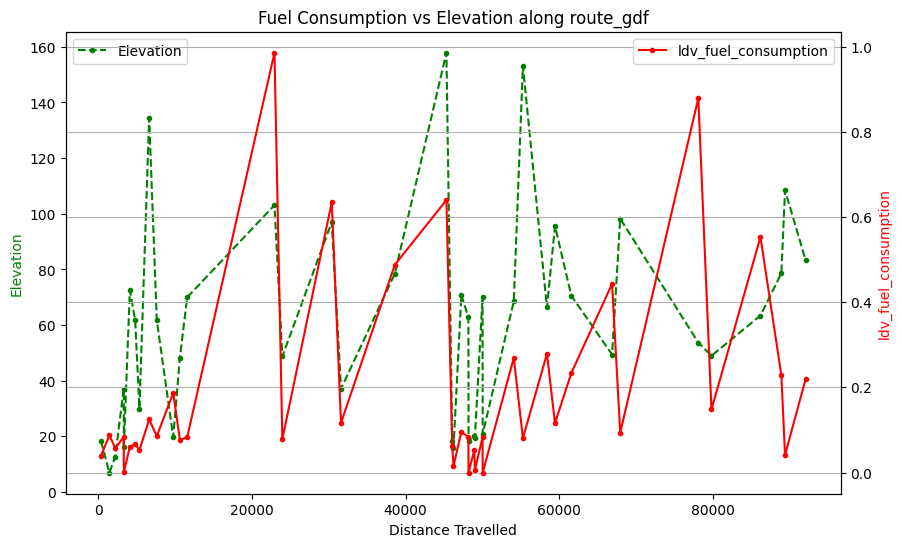

In [39]:

import matplotlib.pyplot as plt

# Assuming you have already extracted 'd_covered', 'elevation', and 'ldv_fuel_consumption' from your route_gdf DataFrame

# Create the line graph
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

# Plot 'Distance Travelled' vs 'Elevation' on the left y-axis
ax1 = plt.gca()  # Get the current axis
ax1.plot(d_covered, route_gdf['elevation'], marker='.', linestyle='--', color='g', label='Elevation')

# Add labels and a title for the left y-axis
ax1.set_xlabel('Distance Travelled')
ax1.set_ylabel('Elevation', color='g')
ax1.set_title('Fuel Consumption vs Elevation along route_gdf')

# Create a second y-axis on the right
ax2 = ax1.twinx()

# Plot 'Distance Travelled' vs 'ldv_fuel_consumption' on the right y-axis
ax2.plot(d_covered, route_gdf['ldv_fuel_consumption'], marker='.', linestyle='-', color='r', label='ldv_fuel_consumption')

# Add labels and a title for the right y-axis
ax2.set_ylabel('ldv_fuel_consumption', color='r')

# Add a legend to distinguish between the two plots
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the graph
plt.grid(True)  # Add gridlines if desired
plt.show()


In [40]:
sum(subroute_ldv_fuel_consumptions)

7.927421775311454

### Medium Duty Vehicle


In [59]:
# Assigning new values to the variables
Fk = 0.20
Nk = 34
Vk = 7
Ak = 7.6
Ckd = 0.55
Ckr = 0.009
rk = 0
wk = 5500
kappa = 45
epsi = 0.4
EP = 0.9
xi = 1
psi = 737
rho = 1.2041
g = 9.81


In [62]:
conversion_factor = 0.44704  # Conversion factor from mph to m/s

# subroute_mdv_fuel_consumptions = []  # Store the fuel consumption for each subroute
distance_covered = 0
d_covered = []

for i in range (-6,7,1):
  subroute_mdv_fuel_consumptions = []
  for index, (idx, row) in enumerate(route_gdf.iterrows()):
      d = row.length
      phi = math.radians(i)
      x = 500

      # Get the corresponding site ID from site_ids_route_order
      site_id = site_ids_route_order[index]

      # Get the average speed from site_timestamps, or assume 70 mph if not found
      avg_speed_mph = site_timestamps.get(site_id, {"average_speed_mph": 70})["average_speed_mph"]
      avg_speed_mps = avg_speed_mph * conversion_factor

      distance_covered += d
      d_covered.append(distance_covered)

      mdv_fuel = (((xi * Fk * Nk * Vk / (kappa * psi))) * (d / avg_speed_mps)) + ((1 / (1000 * epsi * EP * kappa * psi)) * (rk + g * math.sin(phi) + g * Ckr * math.cos(phi)) * (wk + x)) + (0.5 * Ckd * Ak * rho * d * (avg_speed_mps ** 2) / (1000 * epsi * EP * kappa * psi))
      subroute_mdv_fuel_consumptions.append(mdv_fuel)
  print(sum(subroute_mdv_fuel_consumptions))

# route_gdf["mdv_fuel_consumption"] = subroute_mdv_fuel_consumptions


19.017454809831115
19.020969326782822
19.024488657849776
19.028011731009645
19.031537473100204
19.03506481014628
19.038592667686814
19.04211997110225
19.045645645941768
19.049168618250686
19.052687814897496
19.0562021639008
19.059710594755867


In [43]:
sum(subroute_mdv_fuel_consumptions)

19.05584377435706

### Heavy Duty Vehicles

In [53]:
# Assign new values to the variables for HDV
Fk = 0.17
Nk = 33
Vk = 11
Ak = 8.2
Ckd = 0.70
Ckr = 0.008
rk = 0
wk = 13000
kappa = 45
epsi = 0.4
EP = 0.9
xi = 1
psi = 737
rho = 1.2041
g = 9.81


In [55]:
conversion_factor = 0.44704  # Conversion factor from mph to m/s

subroute_hdv_fuel_consumptions = []  # Store the fuel consumption for each subroute
distance_covered = 0
d_covered = []

for i in range (-6,7,1):
  subroute_hdv_fuel_consumptions = []
  for index, (idx, row) in enumerate(route_gdf.iterrows()):
      d = row.length
      phi = math.radians(i)
      x = 500

      # Get the corresponding site ID from site_ids_route_order
      site_id = site_ids_route_order[index]

      # Get the average speed from site_timestamps, or assume 70 mph if not found
      avg_speed_mph = site_timestamps.get(site_id, {"average_speed_mph": 70})["average_speed_mph"]
      avg_speed_mps = avg_speed_mph * conversion_factor

      distance_covered += d
      d_covered.append(distance_covered)

      hdv_fuel = (((xi * Fk * Nk * Vk / (kappa * psi))) * (d / avg_speed_mps)) + ((1 / (1000 * epsi * EP * kappa * psi)) * (rk + g * math.sin(phi) + g * Ckr * math.cos(phi)) * (wk + x)) + (0.5 * Ckd * Ak * rho * d * (avg_speed_mps ** 2) / (1000 * epsi * EP * kappa * psi))
      subroute_hdv_fuel_consumptions.append(hdv_fuel)
  print(sum(subroute_hdv_fuel_consumptions))

# route_gdf["hdv_fuel_consumption"] = subroute_hdv_fuel_consumptions


25.705707232238197
25.713614134617455
25.72153200676015
25.729458436805714
25.737391010286785
25.745327310864617
25.753264921065195
25.761201423015542
25.769134399180288
25.777061433098062
25.784980110117512
25.79288801813291
25.8007827483189


In [46]:
sum(subroute_hdv_fuel_consumptions)

25.7940880598927

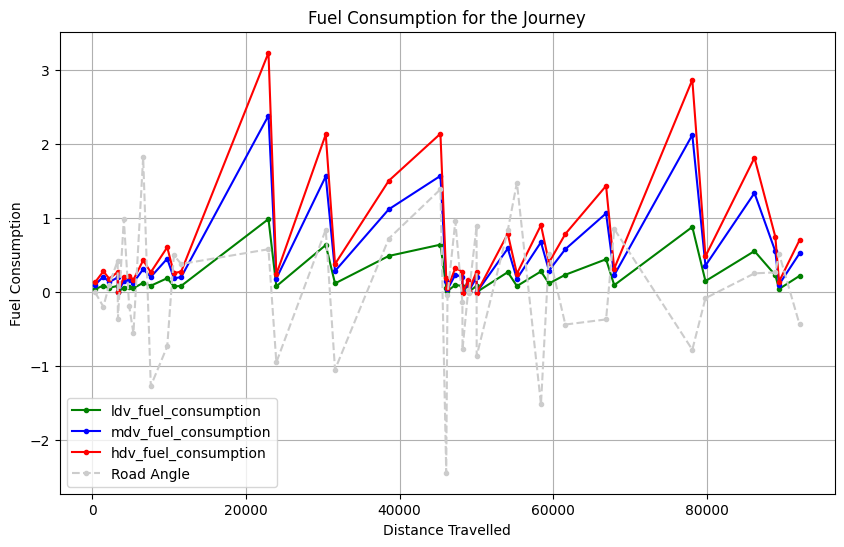

In [51]:
# Create the line graph with three variables
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

# Plot 'd' vs 'phi' with blue color and markers
plt.plot(d_covered,  route_gdf['ldv_fuel_consumption'], marker='.', linestyle='-', color='g', label='ldv_fuel_consumption')

# Plot 'd' vs 'phi' with blue color and markers
plt.plot(d_covered,  route_gdf['mdv_fuel_consumption'], marker='.', linestyle='-', color='b', label='mdv_fuel_consumption')

# Plot 'd' vs 'phi' with blue color and markers
plt.plot(d_covered,  route_gdf['hdv_fuel_consumption'], marker='.', linestyle='-', color='r', label='hdv_fuel_consumption')

plt.plot(d_covered,  route_gdf['delta_phi'], marker='.', linestyle='--', color='0.8', label='Road Angle')

# Add labels and a title
plt.xlabel('Distance Travelled')
plt.ylabel('Fuel Consumption')
plt.title('Fuel Consumption for the Journey')

# Add a legend to distinguish between the two plots
plt.legend()

# Show the graph
plt.grid(True)  # Add gridlines if desired
plt.show()


In [ ]:
# Find and plot the green dots with flag icons for the points where the site_ids_route_order is located
for site_id in site_ids_route_order:
    api1_url = f"https://webtris.nationalhighways.co.uk/api/v1.0/sites/{site_id}"
    response = requests.get(api1_url)
    if response.status_code == 200:
        site_data = response.json()["sites"][0]
        site_point = (site_data["Latitude"], site_data["Longitude"])
        popup_text = f"Site ID: {site_id}\nName: {site_data['Name']}"
        folium.Marker(site_point, icon=folium.Icon(icon="flag", color="green"), popup=popup_text).add_to(m)


In [ ]:
# Create a GeoJSON representation of the route
geojson_route = route_gdf.to_json()

# Add the route to the map
folium.GeoJson(
    geojson_route,
    name='route',
    style_function=lambda x: {'color': 'red', 'weight': 2.5, 'opacity': 1},
    tooltip=folium.features.GeoJsonTooltip(fields=['ldv_fuel_consumption'], aliases=['ldv_fuel_consumption'])
).add_to(m)

# Display the map
m

In [ ]:
route_gdf